# Ungraded Lab: Predicting Sunspots with Neural Networks

At this point in the course, you should be able to explore different network architectures for forecasting. In the previous weeks, you've used DNNs, RNNs, and CNNs to build these different models. In the final practice lab for this course, you'll try one more configuration and that is a combination of all these types of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. See if this improves results or you can just opt for simpler models.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [3]:
# Download the Dataset
!wget -nc https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2025-03-16 17:09:58--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 74.125.142.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2025-03-16 17:09:59 (82.8 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



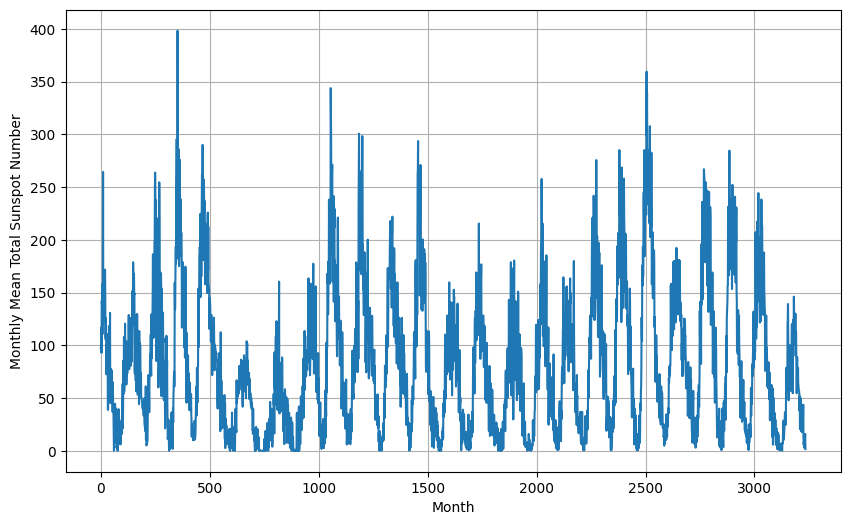

In [4]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

In [5]:
# Define the split time
split_time = 1000

def split_train_valid_data(time, series, split_time):
    """
    Split the time series data into training and validation sets based on the split time.

    Args:
    time (numpy array): Time values of the series.
    series (numpy array): Series data to be split.
    split_time (int): Time value for splitting the data into training and validation sets.

    Returns:
    tuple: Tuple containing time_train, x_train, time_valid, x_valid.
    """
    # Get the train set
    time_train = time[:split_time]
    x_train = series[:split_time]

    # Get the validation set
    time_valid = time[split_time:]
    x_valid = series[split_time:]

    return time_train, x_train, time_valid, x_valid

time_train, x_train, time_valid, x_valid = split_train_valid_data(time, series, split_time)

## Prepare Features and Labels

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size)

    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)

    return dataset

As mentioned in the lectures, if your results don't look good, you can try tweaking the parameters here and see if the model will learn better.

In [7]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

You've seen these layers before and here is how it looks like when combined.

In [8]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda
from tensorflow.keras.optimizers import SGD

class Model:
    def __init__(self, window_size):
        self.window_size = window_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Input(shape=(window_size,1)),
            Conv1D(filters=64, kernel_size=3,
                                   strides=1,
                                   activation="relu",
                                   padding='causal'),
            LSTM(units=64, return_sequences=True),
            LSTM(units=64),
            Dense(units=30, activation="relu"),
            Dense(units=10, activation="relu"),
            Dense(units=1),
            Lambda(lambda x: x * 400)
        ])
        return model

    def compile_model(self, loss='mse', optimizer=SGD(learning_rate=1e-6, momentum=0.9), metrics=None):
        self.model.compile(
            loss=loss,
            optimizer=optimizer,
            metrics=metrics if metrics else []
        )

    def train_model(self, dataset, num_epochs, validation_data=None, callbacks=None, verbose=1):
        history = self.model.fit(
            dataset,
            epochs=num_epochs,
            validation_data=validation_data,
            callbacks=callbacks if callbacks else [],
            verbose=verbose
        )
        return history

    def summary(self):
        self.model.summary()

    def prediction_model(self, data, verbose=0):
        predictions = self.model.predict(data, verbose)
        return predictions


# Create an instance of the Model class
model = Model(window_size)

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 30, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           1,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.

In [10]:
# Get initial weights
init_weights = model.model.get_weights()

In [11]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile_model(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.train_model(train_set, num_epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 131.4096 - learning_rate: 1.0000e-08
Epoch 2/100
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 116.9667

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 116.7552 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 102.9530 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 92.9918 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 84.9869 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 77.1309 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 69.0402 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 60.8941 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 53.1212 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46.3851 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 41.6197 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss

(1e-08, 0.001, 0.0, 100.0)

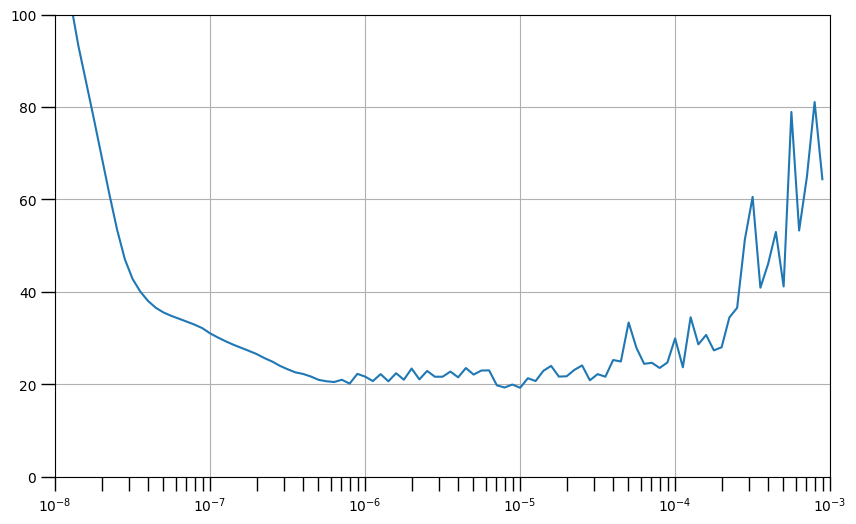

In [12]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [14]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.model.set_weights(init_weights)

In [15]:
# Set the learning rate
learning_rate = 3e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile_model(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [17]:
# Train the model
history = model.train_model(train_set, num_epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 102.3934 - mae: 102.8929
Epoch 2/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34.6812 - mae: 35.1801

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34.8344 - mae: 35.3330
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.0162 - mae: 29.5073
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26.2524 - mae: 26.7461
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.4578 - mae: 24.9512
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.1126 - mae: 23.6040
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.1657 - mae: 22.6573
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.4360 - mae: 21.9292
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.8596 - mae: 21.3506
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.3163 - mae: 20.8095
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.8435 - mae: 20.3356
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.4522 - mae: 19.9427
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.0988 - mae: 19.5883
Epoch 14/100
31/31 ━━━━━

You can visualize the training and see if the loss and MAE are still trending down.

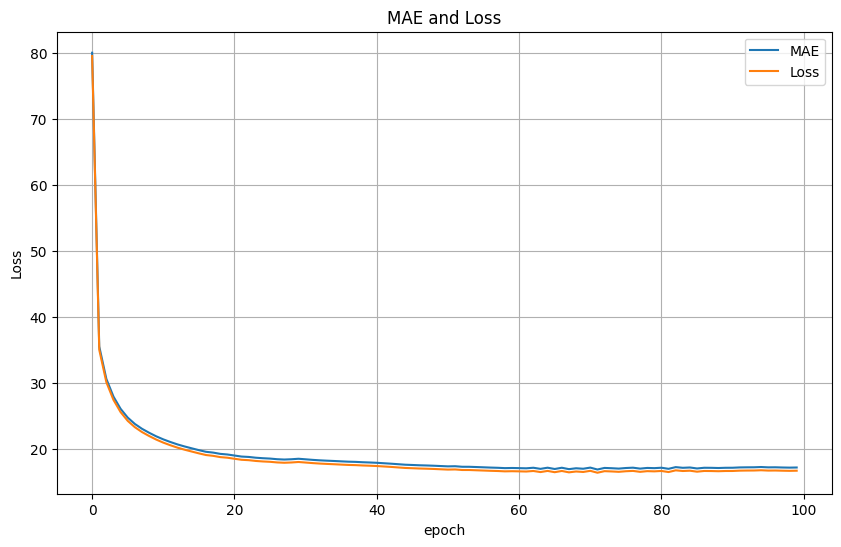

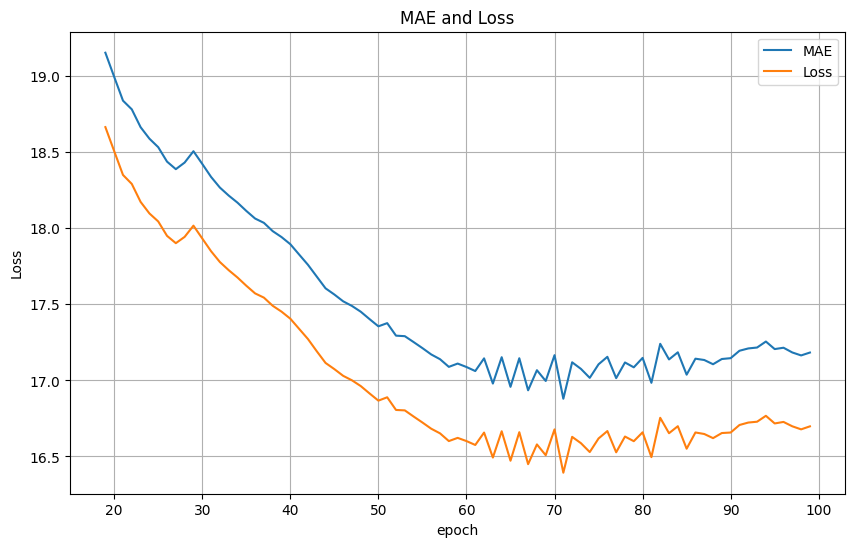

In [18]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [19]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)

    return forecast

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


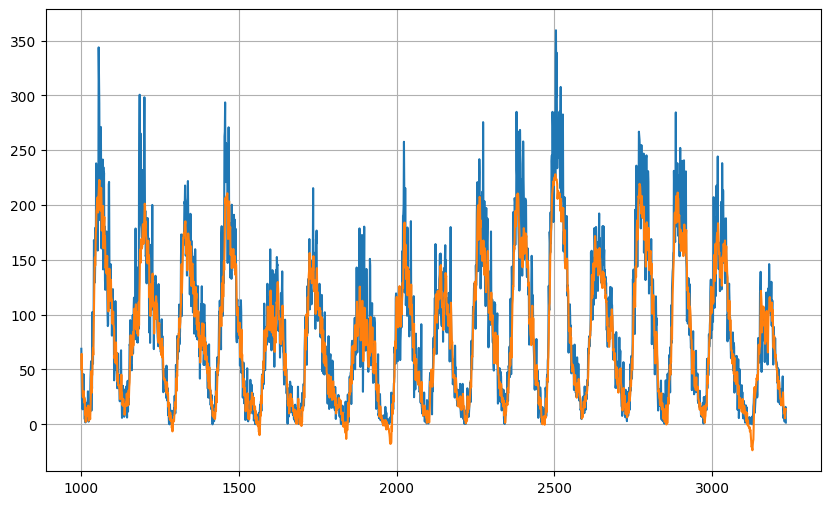

In [21]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model.model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [22]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

19.018488


## Wrap Up

This concludes the final practice lab for this course! You implemented a deep and complex architecture composed of CNNs, RNNs, and DNNs. You'll be using the skills you developed throughout this course to complete the final assignment. Keep it up!